# Pyspark TensorFlow Inference

## Text classification
Based on: https://www.tensorflow.org/tutorials/keras/text_classification

In [1]:
import os
import re
import shutil
import string

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, losses

2024-09-24 05:00:24.278141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 05:00:24.295412: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 05:00:24.300478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 05:00:24.313486: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-24 05:00:25.015644: W tensorflow/comp

In [2]:
print(tf.__version__)

2.17.0


In [3]:
# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(
    "aclImdb_v1", url, untar=True, cache_dir=".", cache_subdir=""
)

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
os.listdir(dataset_dir)

['README', 'train', 'test', 'imdb.vocab', 'imdbEr.txt']

In [6]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['urls_neg.txt',
 'labeledBow.feat',
 'unsup',
 'urls_unsup.txt',
 'pos',
 'urls_pos.txt',
 'unsupBow.feat',
 'neg']

In [7]:
sample_file = os.path.join(train_dir, "pos/1181_9.txt")
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [8]:
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

In [9]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2024-09-24 05:00:47.198582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31135 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB-H, pci bus id: 0000:34:00.0, compute capability: 7.0
2024-09-24 05:00:47.199985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31135 MB memory:  -> device: 1, name: Tesla V100-SXM3-32GB-H, pci bus id: 0000:36:00.0, compute capability: 7.0
2024-09-24 05:00:47.201278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 31135 MB memory:  -> device: 2, name: Tesla V100-SXM3-32GB-H, pci bus id: 0000:39:00.0, compute capability: 7.0
2024-09-24 05:00:47.202542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 31135 MB memory:  -> device: 3, name: Tesla V100-SXM3-32GB-H, pc

In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

2024-09-24 05:00:48.166490: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [12]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [14]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

In [15]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [16]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2024-09-24 05:00:53.210384: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [18]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [19]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [20]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
embedding_dim = 16

In [23]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [25]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


I0000 00:00:1727154054.377099   85287 service.cc:146] XLA service 0x7f6120049cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727154054.377122   85287 service.cc:154]   StreamExecutor device (0): Tesla V100-SXM3-32GB-H, Compute Capability 7.0
I0000 00:00:1727154054.377125   85287 service.cc:154]   StreamExecutor device (1): Tesla V100-SXM3-32GB-H, Compute Capability 7.0
I0000 00:00:1727154054.377128   85287 service.cc:154]   StreamExecutor device (2): Tesla V100-SXM3-32GB-H, Compute Capability 7.0
I0000 00:00:1727154054.377130   85287 service.cc:154]   StreamExecutor device (3): Tesla V100-SXM3-32GB-H, Compute Capability 7.0
I0000 00:00:1727154054.377133   85287 service.cc:154]   StreamExecutor device (4): Tesla V100-SXM3-32GB-H, Compute Capability 7.0
I0000 00:00:1727154054.377135   85287 service.cc:154]   StreamExecutor device (5): Tesla V100-SXM3-32GB-H, Compute Capability 7.0
I0000 00:00:1727154054.377137   85287 service.cc:15

103/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.5374 - loss: 0.6917

I0000 00:00:1727154055.431686   85287 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - binary_accuracy: 0.5888 - loss: 0.6808 - val_binary_accuracy: 0.7374 - val_loss: 0.6110
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - binary_accuracy: 0.7574 - loss: 0.5781 - val_binary_accuracy: 0.8124 - val_loss: 0.4969
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - binary_accuracy: 0.8248 - loss: 0.4656 - val_binary_accuracy: 0.8286 - val_loss: 0.4276
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - binary_accuracy: 0.8527 - loss: 0.3938 - val_binary_accuracy: 0.8410 - val_loss: 0.3854
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step - binary_accuracy: 0.8700 - loss: 0.3467 - val_binary_accuracy: 0.8436 - val_loss: 0.3630
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - binary_accuracy: 0.8815 - loss: 0.3137 - val_binary_accuracy: 0.8568 - val_loss: 0.3396
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step - binary_accuracy: 0.8911 - loss: 0.2901 - val_binary_accuracy: 0.8536 - val_loss: 0.3331
Epoch

In [26]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8594 - loss: 0.3321
Loss:  0.3310850262641907
Accuracy:  0.8562399744987488


In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

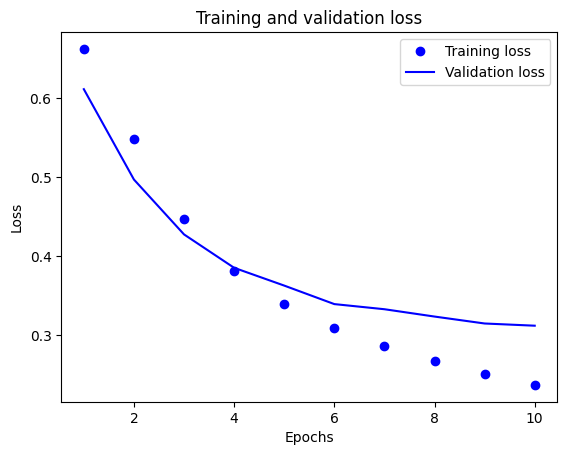

In [28]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

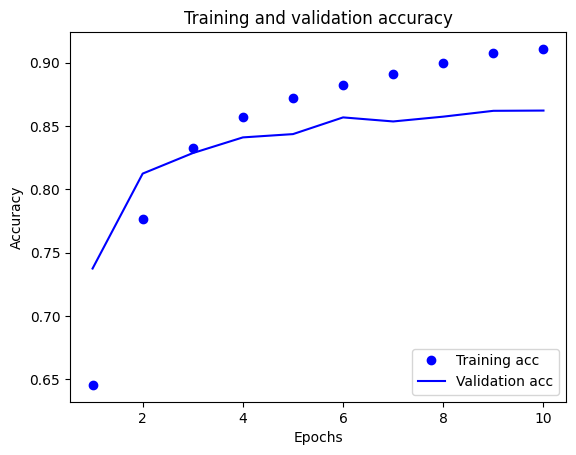

In [29]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [30]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4984 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00
{'accuracy': 0.5, 'binary_accuracy': 0.0, 'loss': 0.0}


In [31]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


array([[0.5816365],
       [0.5468077],
       [0.533961 ]], dtype=float32)

### Save Model

In [32]:
!rm -rf text_model

In [33]:
export_model.save('text_model.keras')

### Load model

In [34]:
# register callables as custom objects before loading
custom_objects = {"vectorize_layer": vectorize_layer, "custom_standardization": custom_standardization}
with tf.keras.utils.custom_object_scope(custom_objects):
    new_model = tf.keras.models.load_model('text_model.keras', compile=False)

new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 250)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 1)              │       160,017 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,017 (625.07 KB)

 Trainable params: 160,017 (625.07 KB)

 Non-trainable params: 0 (0.00 B)

### Predict

In [35]:
new_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


array([[0.5816365],
       [0.5468077],
       [0.533961 ]], dtype=float32)

## PySpark

## Inference using Spark DL API
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [36]:
import os
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col
from pyspark.sql.types import ArrayType, FloatType, DoubleType
from pyspark.sql import SparkSession

In [37]:
num_threads = 6

# Creating a local Spark session for demonstration, in case it hasn't already been created.

_config = {
    "spark.master": f"local[{num_threads}]",
    "spark.driver.host": "127.0.0.1",
    "spark.task.maxFailures": "1",
    "spark.driver.memory": "8g",
    "spark.executor.memory": "8g",
    "spark.sql.execution.pyspark.udf.simplifiedTraceback.enabled": "false",
    "spark.sql.pyspark.jvmStacktrace.enabled": "true",
    "spark.sql.execution.arrow.pyspark.enabled": "true",
    "spark.python.worker.reuse": "true",
}
spark = SparkSession.builder.appName("spark-dl-example")
for key, value in _config.items():
    spark = spark.config(key, value)
spark = spark.getOrCreate()

sc = spark.sparkContext

24/09/24 05:01:09 WARN Utils: Your hostname, dgx2h0194.spark.sjc4.nvmetal.net resolves to a loopback address: 127.0.1.1; using 10.150.30.2 instead (on interface enp134s0f0np0)
24/09/24 05:01:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/24 05:01:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/24 05:01:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/09/24 05:01:10 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/09/24 05:01:10 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/09/24 05:01:10 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
24/09/24 05:01:10 WARN Utils: Service 'SparkUI' could not bind on p

In [40]:
from datasets import load_dataset

# load IMDB reviews (test) dataset
data = load_dataset("imdb", split="test")
lines = []
for example in data:
    lines.append([example["text"].split(".")[0]])
    
df = spark.createDataFrame(lines, ['lines']).repartition(10)

/rishic/anaconda3/envs/spark-rapids-tf-andcuda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
text_model_path = "{}/text_model.keras".format(os.getcwd())

In [42]:
def predict_batch_fn():
    # since this function runs on the executor, any required imports should be added inside the function.
    import re
    import string
    import tensorflow as tf
    from tensorflow.keras import layers

    # Enable GPU memory growth to avoid CUDA OOM
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    def custom_standardization(input_data):
        lowercase = tf.strings.lower(input_data)
        stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
        return tf.strings.regex_replace(
            stripped_html, "[%s]" % re.escape(string.punctuation), ""
        )

    max_features = 10000
    sequence_length = 250

    vectorize_layer = layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode="int",
        output_sequence_length=sequence_length,
    )

    custom_objects = {"vectorize_layer": vectorize_layer,
                      "custom_standardization": custom_standardization}
    with tf.keras.utils.custom_object_scope(custom_objects):
        model = tf.keras.models.load_model(text_model_path)

    def predict(inputs):
        return model.predict(inputs)

    return predict

In [43]:
classify = predict_batch_udf(predict_batch_fn,
                             return_type=FloatType(),
                             batch_size=256)

In [44]:
%%time
predictions = df.withColumn("preds", classify(struct("lines")))
results = predictions.collect()

2024-09-24 05:03:16.581139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 05:03:16.581137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 05:03:16.588265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 05:03:16.596917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 05:03:16.596917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for 

CPU times: user 150 ms, sys: 135 ms, total: 284 ms
Wall time: 32.1 s


In [45]:
%%time
predictions = df.withColumn("preds", classify("lines"))
results = predictions.collect()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  6) / 10]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━

CPU times: user 77.6 ms, sys: 27.2 ms, total: 105 ms
Wall time: 5.62 s


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  1) / 10]


In [46]:
%%time
predictions = df.withColumn("preds", classify(col("lines")))
results = predictions.collect()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  6) / 10]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
8/8 ━━━━━━━━━━━━━

CPU times: user 325 ms, sys: 43.8 ms, total: 368 ms
Wall time: 5.74 s


In [47]:
predictions.show(truncate=80)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


+--------------------------------------------------------------------------------+----------+
|                                                                           lines|     preds|
+--------------------------------------------------------------------------------+----------+
|i do not understand at all why this movie received such good grades from crit...|0.50065273|
|After watching this movie on tv, I looked it up in the IMDB and imagine to my...|0.55972606|
|                                               "The New hope of Romanian cinema"| 0.5659337|
|                                     I think vampire movies (usually) are wicked|0.55427283|
|I enjoyed Oceans 11, I thought it was quite enjoyable, helped by the performa...|0.63838077|
|                                Not to be mistaken as the highly touted Samuel L| 0.5749458|
|      The story of Macbeth was one of the most successful Shakespeare ever wrote| 0.5580002|
|            Peter Crawford discovers a comet on a collision

### Using Triton Inference Server

Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

This notebook uses the [Python backend with a custom execution environment](https://github.com/triton-inference-server/python_backend#creating-custom-execution-environments) for Triton 24.08, using a conda-pack environment created as follows:
```
conda create -n tf-gpu -c conda-forge python=3.10.0
conda activate tf-gpu

export PYTHONNOUSERSITE=True
pip install numpy<2 tensorflow[and-cuda] conda-pack

conda pack  # tf-gpu.tar.gz
```

In [50]:
import numpy as np
import os
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import col, struct
from pyspark.sql.types import ArrayType, FloatType

In [54]:
%%bash
# copy custom model to expected layout for Triton
rm -rf models
mkdir -p models
cp -r models_config/text_classification models

# add custom execution environment
cp tf-gpu.tar.gz models

In [52]:
import unicodedata

def normalize_vocabulary(vocab):
    # Normalize each word in the vocabulary to remove non-ASCII characters
    normalized_vocab = [
        unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8')
        for word in vocab
    ]
    normalized_vocab = filter(lambda x: x != '', normalized_vocab)
    normalized_vocab = list(set(normalized_vocab)) 


    return normalized_vocab

vocab = vectorize_layer.get_vocabulary()
normalized_vocab = normalize_vocabulary(vocab)

# Reassign the cleaned vocabulary to the TextVectorization layer
vectorize_layer.set_vocabulary(normalized_vocab)

# Save the model with the cleaned vocabulary
export_model.save('text_model_cleaned.keras')

#### Start Triton Server on each executor

In [55]:
num_executors = 1
triton_models_dir = "{}/models".format(os.getcwd())
text_model_dir = "{}/text_model_cleaned.keras".format(os.getcwd())
nodeRDD = sc.parallelize(list(range(num_executors)), num_executors)

def start_triton(it):
    import docker
    import time
    import tritonclient.grpc as grpcclient
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    if containers:
        print(">>>> containers: {}".format([c.short_id for c in containers]))
    else:
        container=client.containers.run(
            "nvcr.io/nvidia/tritonserver:24.08-py3", "tritonserver --model-repository=/models",
            detach=True,
            device_requests=[docker.types.DeviceRequest(device_ids=["0"], capabilities=[['gpu']])],
            name="spark-triton",
            network_mode="host",
            remove=True,
            shm_size="128M",
            volumes={
                triton_models_dir: {"bind": "/models", "mode": "ro"},
                text_model_dir: {"bind": "/text_model_cleaned.keras", "mode": "ro"}
            }
        )
        print(">>>> starting triton: {}".format(container.short_id))

        # wait for triton to be running
        time.sleep(15)
        client = grpcclient.InferenceServerClient("localhost:8001")
        ready = False
        while not ready:
            try:
                ready = client.is_server_ready()
            except Exception as e:
                time.sleep(5)
            
    return [True]

nodeRDD.barrier().mapPartitions(start_triton).collect()

>>>> starting triton: 1e5c99d2ef76) / 1][Stage 13:>                 (0 + 1) / 1]


[True]

#### Run inference

In [57]:
from datasets import load_dataset

# load IMDB reviews (test) dataset
data = load_dataset("imdb", split="test")
lines = []
for example in data:
    lines.append([example["text"].split(".")[0]])

df = spark.createDataFrame(lines, ['lines']).repartition(10)
df.show(truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                               lines|
+----------------------------------------------------------------------------------------------------+
|i do not understand at all why this movie received such good grades from critics - - i've seen te...|
|After watching this movie on tv, I looked it up in the IMDB and imagine to my surprise a user rat...|
|                                                                   "The New hope of Romanian cinema"|
|                                                         I think vampire movies (usually) are wicked|
| I enjoyed Oceans 11, I thought it was quite enjoyable, helped by the performances and the direction|
|                                                    Not to be mistaken as the highly touted Samuel L|
|                          The story of Macbeth was one of the most succe

Exception in thread "serve RDD 39" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


In [58]:
columns = df.columns
columns

['lines']

In [59]:
def triton_fn(triton_uri, model_name):
    import numpy as np
    import tritonclient.grpc as grpcclient
    
    np_types = {
      "BOOL": np.dtype(np.bool_),
      "INT8": np.dtype(np.int8),
      "INT16": np.dtype(np.int16),
      "INT32": np.dtype(np.int32),
      "INT64": np.dtype(np.int64),
      "FP16": np.dtype(np.float16),
      "FP32": np.dtype(np.float32),
      "FP64": np.dtype(np.float64),
      "FP64": np.dtype(np.double),
      "BYTES": np.dtype(object)
    }

    client = grpcclient.InferenceServerClient(triton_uri)
    model_meta = client.get_model_metadata(model_name)
    
    def predict(inputs):
        if isinstance(inputs, np.ndarray):
            # single ndarray input
            request = [grpcclient.InferInput(model_meta.inputs[0].name, inputs.shape, model_meta.inputs[0].datatype)]
            request[0].set_data_from_numpy(inputs.astype(np_types[model_meta.inputs[0].datatype]))
        else:
            # dict of multiple ndarray inputs
            request = [grpcclient.InferInput(i.name, inputs[i.name].shape, i.datatype) for i in model_meta.inputs]
            for i in request:
                i.set_data_from_numpy(inputs[i.name()].astype(np_types[i.datatype()]))
        
        response = client.infer(model_name, inputs=request)
        
        if len(model_meta.outputs) > 1:
            # return dictionary of numpy arrays
            return {o.name: response.as_numpy(o.name) for o in model_meta.outputs}
        else:
            # return single numpy array
            return response.as_numpy(model_meta.outputs[0].name)
        
    return predict

In [60]:
from functools import partial

classify = predict_batch_udf(partial(triton_fn, triton_uri="localhost:8001", model_name="text_classification"),
                             input_tensor_shapes=[[1]],
                             return_type=FloatType(),
                             batch_size=2048)

In [61]:
%%time
df.withColumn("preds", classify(struct(*columns))).show(truncate=80)

+--------------------------------------------------------------------------------+----------+
|                                                                           lines|     preds|
+--------------------------------------------------------------------------------+----------+
|i do not understand at all why this movie received such good grades from crit...| 0.5776406|
|After watching this movie on tv, I looked it up in the IMDB and imagine to my...| 0.5778101|
|                                               "The New hope of Romanian cinema"|0.56644225|
|                                     I think vampire movies (usually) are wicked| 0.5520439|
|I enjoyed Oceans 11, I thought it was quite enjoyable, helped by the performa...| 0.5750631|
|                                Not to be mistaken as the highly touted Samuel L| 0.5441934|
|      The story of Macbeth was one of the most successful Shakespeare ever wrote|0.58949274|
|            Peter Crawford discovers a comet on a collision

In [62]:
%%time
df.withColumn("preds", classify(*columns)).show(truncate=80)

+--------------------------------------------------------------------------------+----------+
|                                                                           lines|     preds|
+--------------------------------------------------------------------------------+----------+
|i do not understand at all why this movie received such good grades from crit...| 0.5776406|
|After watching this movie on tv, I looked it up in the IMDB and imagine to my...| 0.5778101|
|                                               "The New hope of Romanian cinema"|0.56644225|
|                                     I think vampire movies (usually) are wicked| 0.5520439|
|I enjoyed Oceans 11, I thought it was quite enjoyable, helped by the performa...| 0.5750631|
|                                Not to be mistaken as the highly touted Samuel L| 0.5441934|
|      The story of Macbeth was one of the most successful Shakespeare ever wrote|0.58949274|
|            Peter Crawford discovers a comet on a collision

#### Stop Triton Server on each executor

In [63]:
def stop_triton(it):
    import docker
    import time
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    print(">>>> stopping containers: {}".format([c.short_id for c in containers]))
    if containers:
        container=containers[0]
        container.stop(timeout=120)

    return [True]

nodeRDD.barrier().mapPartitions(stop_triton).collect()

>>>> stopping containers: ['1e5c99d2ef76']


[True]

In [64]:
spark.stop()